In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

file_path = r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx"
df = pd.read_excel(file_path)

In [2]:
df = df[df["TaggedPitchType"].notna()]
df = df[df["AutoPitchType"].notna()]
df = df[df["PitcherThrows"].notna()]
df = df[df["Pitcher"].notna()]

df["TaggedPitchType"] = df["TaggedPitchType"].str.title().str.strip()
df["AutoPitchType"] = df["AutoPitchType"].str.title().str.strip()

df["NormalizedHorzBreak"] = df.apply(
    lambda row: -row["HorzBreak"] if row["PitcherThrows"] == "L" else row["HorzBreak"], axis=1
)

pitch_type_mapping = {
    "Fastball": "Four-Seam",
    "Fourseamfastball": "Four-Seam",
    "Twoseamfastball": "Two-Seam",
    "Twoseamfour-Seam": "Two-Seam",
    "Sweeper": "Slider",
}

df["TaggedPitchType"] = df["TaggedPitchType"].replace(pitch_type_mapping)

valid_pitches = ["Four-Seam", "Slider", "Sinker", "Two-Seam", 
                 "Cutter", "Splitter", "Curveball", "Changeup"]
df = df[df["TaggedPitchType"].isin(valid_pitches)]

C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trajectory_cols = [
    "PitchTrajectoryXc0","PitchTrajectoryXc1","PitchTrajectoryXc2",
    "PitchTrajectoryYc0","PitchTrajectoryYc1","PitchTrajectoryYc2",
    "PitchTrajectoryZc0","PitchTrajectoryZc1","PitchTrajectoryZc2"
]
df[trajectory_cols] = df[trajectory_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=trajectory_cols)

min_pitches = 4
pitch_counts = df.groupby(["Pitcher", "TaggedPitchType"]).size().unstack(fill_value=0)
qualified_pitchers = pitch_counts[(pitch_counts >= min_pitches).sum(axis=1) >= 2].index
df = df[df["Pitcher"].isin(qualified_pitchers)]

y_samples = [10, 20, 30]

def sample_trajectory(row, y_samples):
    sampled_points = []
    for y in y_samples:
        x = row["PitchTrajectoryXc0"] + row["PitchTrajectoryXc1"] * y + row["PitchTrajectoryXc2"] * y**2
        y_coord = row["PitchTrajectoryYc0"] + row["PitchTrajectoryYc1"] * y + row["PitchTrajectoryYc2"] * y**2
        z = row["PitchTrajectoryZc0"] + row["PitchTrajectoryZc1"] * y + row["PitchTrajectoryZc2"] * y**2
        sampled_points.extend([x, y_coord, z])
    return pd.Series(sampled_points, index=[f"{axis}_{dist}ft" for dist in y_samples for axis in ['X','Y','Z']])

sampled_df = df.apply(sample_trajectory, axis=1, y_samples=y_samples)

def compute_tunneling_with_release(df, sampled_df):
    all_scores = []
    release_features = ["RelHeight", "RelSide"]
    all_features = release_features + sampled_df.columns.tolist()

    for pitcher, idxs in df.groupby("Pitcher").groups.items():
        pitcher_feats = pd.concat([df.loc[idxs, release_features], sampled_df.loc[idxs]], axis=1)
        pitcher_feats[all_features] = StandardScaler().fit_transform(pitcher_feats)
        pitch_types = df.loc[idxs, "TaggedPitchType"].unique()

        for pt in pitch_types:
            this_idx = df.loc[idxs][df.loc[idxs, "TaggedPitchType"] == pt].index
            other_idx = df.loc[idxs][df.loc[idxs, "TaggedPitchType"] != pt].index
            if len(other_idx) == 0:
                continue

            this_pitch = pitcher_feats.loc[this_idx]
            other_pitch = pitcher_feats.loc[other_idx]
            distances = cdist(this_pitch[all_features], other_pitch[all_features], metric='euclidean')
            tunneling_score = 1 / (1 + distances.mean())

            for pid in this_idx:
                all_scores.append({
                    "PitchId": pid,
                    "Pitcher": pitcher,
                    "TaggedPitchType": pt,
                    "TunnelingScore": tunneling_score
                })

    return pd.DataFrame(all_scores)

tunnel_scores = compute_tunneling_with_release(df, sampled_df)
df["TunnelingScore"] = df.index.map(tunnel_scores.set_index("PitchId")["TunnelingScore"])

pitcher_avg_scores = (
    df.groupby(["Pitcher", "TaggedPitchType"])["TunnelingScore"]
    .mean()
    .reset_index(name="MeanTunnelingScore")
)

pitcher_avg_scores["Deception_z"] = (
    pitcher_avg_scores.groupby("Pitcher")["MeanTunnelingScore"]
    .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

In [4]:
vaa_data = df[["VertApprAngle", "PlateLocHeight"]].dropna()
X = vaa_data["PlateLocHeight"]
X_quad = np.column_stack([X, X**2])
reg = LinearRegression()
reg.fit(X_quad, vaa_data["VertApprAngle"])

X_full_quad = np.column_stack([df["PlateLocHeight"], df["PlateLocHeight"]**2])
df["ExpectedVAA"] = reg.predict(X_full_quad)
df["LA_VAA"] = df["VertApprAngle"] - df["ExpectedVAA"]

def calculate_custom_la_vaa(row):
    pitch = row["TaggedPitchType"]
    la_vaa = row["LA_VAA"]
    if pitch in ["Four-Seam", "Two-Seam"]:
        return abs(la_vaa)
    else:
        return la_vaa

df["CustomLA_VAA"] = df.apply(calculate_custom_la_vaa, axis=1)

In [5]:
def use_correct_vert_break(row):
    pitch = row["TaggedPitchType"].lower()
    if "splitter" in pitch or "changeup" in pitch:
        return -row["InducedVertBreak"]
    elif "four-seam" in pitch or "two-seam" in pitch:
        return row["VertBreak"]
    else:
        return -row["VertBreak"]

df["EffectiveVertBreak"] = df.apply(use_correct_vert_break, axis=1)

In [6]:
mean_rel_height = df["RelHeight"].mean()
mean_rel_side = df["RelSide"].mean()
df["RelHeight_Dev"] = abs(df["RelHeight"] - mean_rel_height)
df["RelSide_Dev"] = abs(df["RelSide"] - mean_rel_side)

In [7]:
zscore_cols = [
    "RelSpeed", "SpinRate", "EffectiveVertBreak", 
    "NormalizedHorzBreak", "Extension", "RelHeight_Dev",
    "CustomLA_VAA",
]

def calculate_zscores(group):
    group = group.copy()
    scaler = StandardScaler()
    zscores = scaler.fit_transform(group[zscore_cols])
    zscores_df = pd.DataFrame(zscores, columns=[f"{col}_z" for col in zscore_cols], index=group.index)
    return pd.concat([group, zscores_df], axis=1)

df_zscored = df.groupby(["PitcherThrows", "TaggedPitchType"], group_keys=False).apply(calculate_zscores)

C:\Users\brend\AppData\Local\Temp\ipykernel_31092\617489434.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_zscored = df.groupby(["PitcherThrows", "TaggedPitchType"], group_keys=False).apply(calculate_zscores)


In [8]:
def adj_spinrate_z(row):
    if row["TaggedPitchType"] in ["Splitter", "Changeup", "Sinker"]:
        return -row["SpinRate_z"]
    return row["SpinRate_z"]

df_zscored["Adj_SpinRate_z"] = df_zscored.apply(adj_spinrate_z, axis=1)

In [9]:
pitches_preferring_more_horz_break = ["Cutter", "Slider", "Curveball"]
def adjust_horz_break_z(row):
    if row["TaggedPitchType"] in pitches_preferring_more_horz_break:
        return row["NormalizedHorzBreak_z"]
    return -row["NormalizedHorzBreak_z"]

df_zscored["Adj_HorzBreak_z"] = df_zscored.apply(adjust_horz_break_z, axis=1)

In [10]:
release_consistency = df.groupby(["Pitcher", "TaggedPitchType"]).agg(
    RelHeight_SD=("RelHeight", "std"),
    Extension_SD=("Extension", "std")
).reset_index()

scaler = StandardScaler()
release_consistency[["RelHeight_Consistency_z", "Extension_Consistency_z"]] = scaler.fit_transform(
    release_consistency[["RelHeight_SD", "Extension_SD"]]
)

release_consistency["RelHeight_Consistency_z"] = -release_consistency["RelHeight_Consistency_z"]
release_consistency["Extension_Consistency_z"] = -release_consistency["Extension_Consistency_z"]

df_zscored = df_zscored.merge(
    release_consistency[['Pitcher','TaggedPitchType','RelHeight_Consistency_z','Extension_Consistency_z']],
    on=['Pitcher','TaggedPitchType'],
    how='left'
)

df_zscored = df_zscored.merge(
    pitcher_avg_scores[['Pitcher','TaggedPitchType','Deception_z']],
    on=['Pitcher','TaggedPitchType'],
    how='left'
)

for col in ['Deception_z', 'RelHeight_Consistency_z', 'Extension_Consistency_z']:
    df_zscored[col] = df_zscored[col].fillna(0)

In [11]:
pitch_type_weights = {
    "Four-Seam": {
        "RelSpeed_z": 0.20,
        "Adj_SpinRate_z": 0.05,
        "EffectiveVertBreak_z": 0.24,
        "Adj_HorzBreak_z": 0.07,
        "Extension_z": 0.06,
        "RelHeight_Dev_z": 0.09,
        "CustomLA_VAA_z": 0.13,
        "Deception_z": 0.05,
        "RelHeight_Consistency_z": 0.05,
        "Extension_Consistency_z": 0.06
    },
    "Sinker": {
        "RelSpeed_z": 0.13,
        "Adj_SpinRate_z": 0.11,
        "EffectiveVertBreak_z": 0.14,
        "Adj_HorzBreak_z": 0.14,
        "Extension_z": 0.09,
        "RelHeight_Dev_z": 0.11,
        "CustomLA_VAA_z": 0.11,
        "Deception_z": 0.04,
        "RelHeight_Consistency_z": 0.07,
        "Extension_Consistency_z": 0.06
    },
    "Two-Seam": {
        "RelSpeed_z": 0.11,
        "Adj_SpinRate_z": 0.11,
        "EffectiveVertBreak_z": 0.13,
        "Adj_HorzBreak_z": 0.06,
        "Extension_z": 0.12,
        "RelHeight_Dev_z": 0.15,
        "CustomLA_VAA_z": 0.21,
        "Deception_z": 0.00,
        "RelHeight_Consistency_z": 0.08,
        "Extension_Consistency_z": 0.03
    },
    "Slider": {
        "RelSpeed_z": 0.16,
        "Adj_SpinRate_z": 0.06,
        "EffectiveVertBreak_z": 0.12,
        "Adj_HorzBreak_z": 0.05,
        "Extension_z": 0.08,
        "RelHeight_Dev_z": 0.07,
        "CustomLA_VAA_z": 0.24,
        "Deception_z": 0.09,
        "RelHeight_Consistency_z": 0.07,
        "Extension_Consistency_z": 0.06
    },
    "Changeup": {
        "RelSpeed_z": 0.08,
        "Adj_SpinRate_z": 0.06,
        "EffectiveVertBreak_z": 0.15,
        "Adj_HorzBreak_z": 0.11,
        "Extension_z": 0.07,
        "RelHeight_Dev_z": 0.08,
        "CustomLA_VAA_z": 0.22,
        "Deception_z": 0.09,
        "RelHeight_Consistency_z": 0.10,
        "Extension_Consistency_z": 0.04
    },
    "Curveball": {
        "RelSpeed_z": 0.12,
        "Adj_SpinRate_z": 0.10,
        "EffectiveVertBreak_z": 0.18,
        "Adj_HorzBreak_z": 0.07,
        "Extension_z": 0.07,
        "RelHeight_Dev_z": 0.09,
        "CustomLA_VAA_z": 0.24,
        "Deception_z": 0.06,
        "RelHeight_Consistency_z": 0.03,
        "Extension_Consistency_z": 0.04
    },
    "Cutter": {
        "RelSpeed_z": 0.12,
        "Adj_SpinRate_z": 0.11,
        "EffectiveVertBreak_z": 0.10,
        "Adj_HorzBreak_z": 0.11,
        "Extension_z": 0.09,
        "RelHeight_Dev_z": 0.10,
        "CustomLA_VAA_z": 0.18,
        "Deception_z": 0.08,
        "RelHeight_Consistency_z": 0.05,
        "Extension_Consistency_z": 0.06
    },
    "Splitter": {
        "RelSpeed_z": 0.11,
        "Adj_SpinRate_z": 0.13,
        "EffectiveVertBreak_z": 0.12,
        "Adj_HorzBreak_z": 0.11,
        "Extension_z": 0.09,
        "RelHeight_Dev_z": 0.09,
        "CustomLA_VAA_z": 0.19,
        "Deception_z": 0.04,
        "RelHeight_Consistency_z": 0.06,
        "Extension_Consistency_z": 0.06
    }
}

def apply_weights(row):
    pitch_type = row["TaggedPitchType"]
    weights = pitch_type_weights.get(pitch_type, pitch_type_weights["Four-Seam"])
    return sum(row.get(col, 0) * weight for col, weight in weights.items())

df_zscored["WeightedStuffPlus"] = df_zscored.apply(apply_weights, axis=1)

mean_wsp = df_zscored["WeightedStuffPlus"].mean()
std_wsp = df_zscored["WeightedStuffPlus"].std()

df_zscored["StuffPlus"] = 100 + 10 * ((df_zscored["WeightedStuffPlus"] - mean_wsp) / std_wsp)

In [12]:
zscore_features = [
    "RelSpeed", "Adj_SpinRate", "EffectiveVertBreak", "NormalizedHorzBreak",
    "Extension", "RelHeight_Dev", "CustomLA_VAA"
]

scaler = StandardScaler()
df_zscored[[f"{col}_z" for col in zscore_features]] = scaler.fit_transform(df_zscored[zscore_features])

if 'Deception_z' in df_zscored.columns:
    df_zscored = df_zscored.drop(columns=['Deception_z'])

merge_cols = ['Pitcher', 'TaggedPitchType', 'Deception_z']
for col in ['RelHeight_Consistency_z', 'Extension_Consistency_z']:
    if col in pitcher_avg_scores.columns:
        merge_cols.append(col)

df_zscored = df_zscored.merge(
    pitcher_avg_scores[merge_cols],
    on=['Pitcher', 'TaggedPitchType'],
    how='left'
)

for col in ['Deception_z', 'RelHeight_Consistency_z', 'Extension_Consistency_z']:
    if col in df_zscored.columns:
        df_zscored[col] = df_zscored[col].fillna(0)

df_zscored['Whiff'] = df_zscored['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

extended_zscore_cols = [
    "RelSpeed_z", "Adj_SpinRate_z", "EffectiveVertBreak_z", "Adj_HorzBreak_z",
    "Extension_z", "RelHeight_Dev_z", "CustomLA_VAA_z", "Deception_z"
]

for col in ['RelHeight_Consistency_z', 'Extension_Consistency_z']:
    if col in df_zscored.columns:
        extended_zscore_cols.append(col)

for col in extended_zscore_cols:
    if col not in df_zscored.columns:
        df_zscored[col] = 0

weights_per_pitch = {}
min_samples = 50

for pitch in df_zscored['TaggedPitchType'].unique():
    pitch_df = df_zscored[df_zscored['TaggedPitchType'] == pitch].copy()
    
    if len(pitch_df) < min_samples:
        continue
    
    X = pitch_df[extended_zscore_cols].fillna(0)
    y = pitch_df['Whiff']
    
    model = xgb.XGBClassifier(
        n_estimators=200, max_depth=3, learning_rate=0.1,
        use_label_encoder=False, eval_metric='logloss'
    )
    model.fit(X, y)
    
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    
    avg_shap = np.abs(shap_values.values).mean(axis=0)
    feature_weights = dict(zip(extended_zscore_cols, avg_shap))
    
    total = sum(feature_weights.values())
    feature_weights = {k: v / total for k, v in feature_weights.items()}
    
    weights_per_pitch[pitch] = feature_weights

def compute_stuffplus(row):
    pitch = row['TaggedPitchType']
    weights = weights_per_pitch.get(pitch)
    
    if not weights:
        weights = {col: 1/len(extended_zscore_cols) for col in extended_zscore_cols}
    
    total = 0
    for col, w in weights.items():
        val = row.get(col, 0)
        total += val * w
    return total

for pitch, w in weights_per_pitch.items():
    print(f"\nWeights for {pitch}:")
    for feature, weight in w.items():
        print(f"{feature}: {weight:.2f}")

C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:26] WARNING: C:\actio


Weights for Changeup:
RelSpeed_z: 0.10
Adj_SpinRate_z: 0.06
EffectiveVertBreak_z: 0.14
Adj_HorzBreak_z: 0.08
Extension_z: 0.06
RelHeight_Dev_z: 0.08
CustomLA_VAA_z: 0.22
Deception_z: 0.09
RelHeight_Consistency_z: 0.10
Extension_Consistency_z: 0.07

Weights for Curveball:
RelSpeed_z: 0.12
Adj_SpinRate_z: 0.11
EffectiveVertBreak_z: 0.16
Adj_HorzBreak_z: 0.09
Extension_z: 0.06
RelHeight_Dev_z: 0.10
CustomLA_VAA_z: 0.23
Deception_z: 0.06
RelHeight_Consistency_z: 0.03
Extension_Consistency_z: 0.05

Weights for Four-Seam:
RelSpeed_z: 0.09
Adj_SpinRate_z: 0.05
EffectiveVertBreak_z: 0.31
Adj_HorzBreak_z: 0.06
Extension_z: 0.06
RelHeight_Dev_z: 0.09
CustomLA_VAA_z: 0.14
Deception_z: 0.07
RelHeight_Consistency_z: 0.05
Extension_Consistency_z: 0.07

Weights for Slider:
RelSpeed_z: 0.14
Adj_SpinRate_z: 0.07
EffectiveVertBreak_z: 0.12
Adj_HorzBreak_z: 0.07
Extension_z: 0.08
RelHeight_Dev_z: 0.07
CustomLA_VAA_z: 0.24
Deception_z: 0.09
RelHeight_Consistency_z: 0.07
Extension_Consistency_z: 0.06

Wei

In [12]:
falmouth_df = df_zscored[df_zscored["PitcherTeam"] == "FAL_COM"]

pitcher_pitchtype_summary = (
    falmouth_df.groupby(["Pitcher", "TaggedPitchType"])
    .agg(
        PitchCount=("RelSpeed", "count"),
        Avg_RelSpeed=("RelSpeed", "mean"),
        Avg_SpinRate=("SpinRate", "mean"),
        Avg_InducedVertBreak=("InducedVertBreak", "mean"),
        Avg_VertBreak=("VertBreak", "mean"),
        Avg_HorzBreak=("HorzBreak", "mean"),
        Avg_Extension=("Extension", "mean"),
        Avg_RelHeight=("RelHeight", "mean"),
        Avg_RelSide=("RelSide", "mean"),
        Avg_VertApprAngle=("VertApprAngle", "mean"),
        Avg_StuffPlus=("StuffPlus", "mean")
    )
    .reset_index()
)

pitcher_pitchtype_summary["Avg_StuffPlus"] = pitcher_pitchtype_summary["Avg_StuffPlus"].round(1)

pitcher_pitchtype_summary["Weighted_StuffPlus"] = (
    pitcher_pitchtype_summary["Avg_StuffPlus"] * pitcher_pitchtype_summary["PitchCount"]
)

total_pitch_counts = pitcher_pitchtype_summary.groupby("Pitcher")["PitchCount"].sum().reset_index(name="TotalPitchCount")

total_weighted_stuff = pitcher_pitchtype_summary.groupby("Pitcher")["Weighted_StuffPlus"].sum().reset_index(name="TotalWeightedStuff")

pitcher_pitchtype_summary = pitcher_pitchtype_summary.merge(total_pitch_counts, on="Pitcher")
pitcher_pitchtype_summary = pitcher_pitchtype_summary.merge(total_weighted_stuff, on="Pitcher")

pitcher_pitchtype_summary["Combined_StuffPlus"] = (
    pitcher_pitchtype_summary["TotalWeightedStuff"] / pitcher_pitchtype_summary["TotalPitchCount"]
).round(1)

metric_cols = [col for col in pitcher_pitchtype_summary.columns if col.startswith("Avg_") and col != "Avg_StuffPlus"]
pitcher_pitchtype_summary[metric_cols] = pitcher_pitchtype_summary[metric_cols].round(2)

pitcher_pitchtype_summary = pitcher_pitchtype_summary.sort_values(
    by=["Combined_StuffPlus", "Avg_StuffPlus"], ascending=[False, False]
)

sorted_pitchers = pitcher_pitchtype_summary.drop_duplicates("Pitcher")["Pitcher"]
rows_with_spacing = []
for pitcher in sorted_pitchers:
    group = pitcher_pitchtype_summary[pitcher_pitchtype_summary["Pitcher"] == pitcher]
    rows_with_spacing.append(group)
    rows_with_spacing.append(pd.DataFrame([[""] * len(group.columns)], columns=group.columns))

falmouth_with_spacing = pd.concat(rows_with_spacing, ignore_index=True)

output_path = r"C:\Users\brend\OneDrive - Stonehill College\Falmouth_Pitcher_StuffPlus_Averages.xlsx"
falmouth_with_spacing.to_excel(output_path, index=False)
print(f"Excel file saved to {output_path}")

Excel file saved to C:\Users\brend\OneDrive - Stonehill College\Falmouth_Pitcher_StuffPlus_Averages.xlsx


In [31]:
df_zscored = df_zscored.sort_values(["Pitcher", "Date", "PitchNo"])

df_zscored["OutingID"] = df_zscored.groupby(["Pitcher", "Date"]).ngroup()
df_zscored["PitchNumber"] = df_zscored.groupby("OutingID").cumcount() + 1

df_zscored["PitchType_Z"] = (
    df_zscored.groupby("TaggedPitchType")["StuffPlus"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

df_zscored["Rolling_StuffPlus_Z"] = (
    df_zscored.groupby("OutingID")["PitchType_Z"]
    .transform(lambda x: x.rolling(10, min_periods=1).mean())
)

outing_summary = (
    df_zscored.groupby("OutingID")
    .agg(
        Pitcher=("Pitcher", "first"),
        Date=("Date", "first"),
        Team=("PitcherTeam", "first"),
        Start_Z=("PitchType_Z", lambda x: x.head(10).mean()),
        End_Z=("PitchType_Z", lambda x: x.tail(10).mean()),
        TotalPitches=("PitchNumber", "max")
    )
    .assign(Delta_Z=lambda d: d["End_Z"] - d["Start_Z"])
    .reset_index(drop=True)
)

falmouth_outings = outing_summary[outing_summary["Team"] == "FAL_COM"]

In [32]:
outing_summary_path = r"C:\Users\brend\OneDrive - Stonehill College\Falmouth_StuffPlusZ_OutingTrends.xlsx"
falmouth_outings.to_excel(outing_summary_path, index=False)
print(f"Falmouth Z-score outing trends saved to {outing_summary_path}")

Falmouth Z-score outing trends saved to C:\Users\brend\OneDrive - Stonehill College\Falmouth_StuffPlusZ_OutingTrends.xlsx


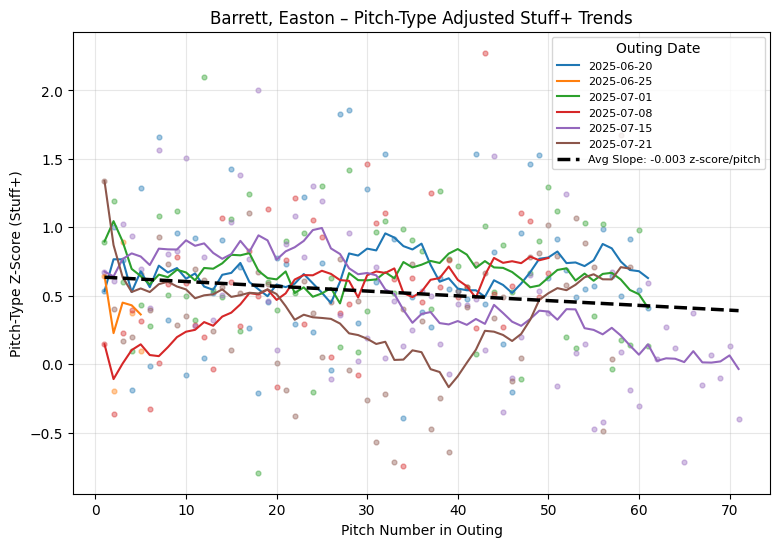

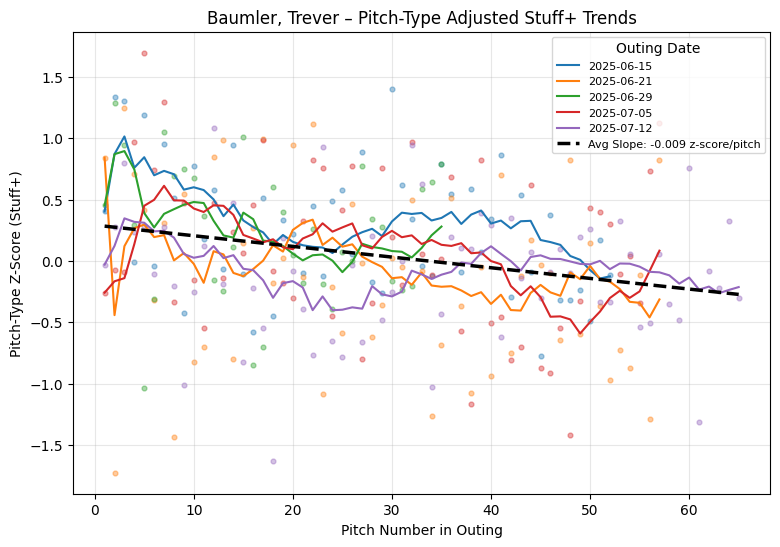

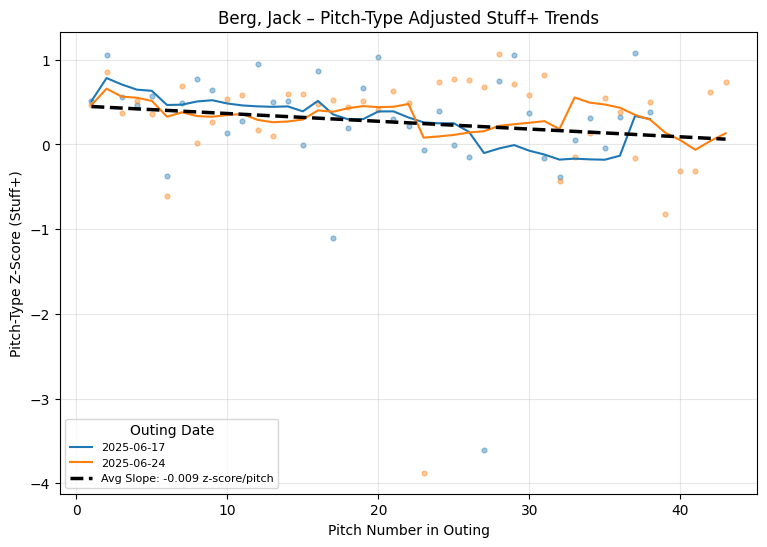

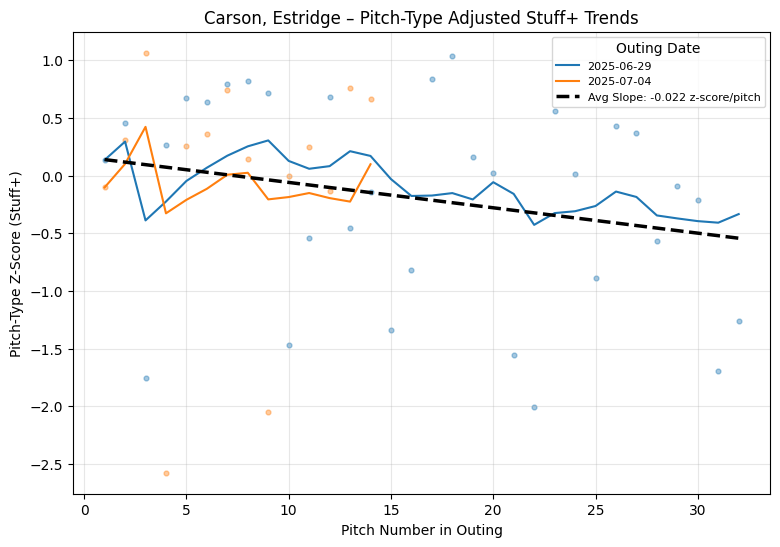

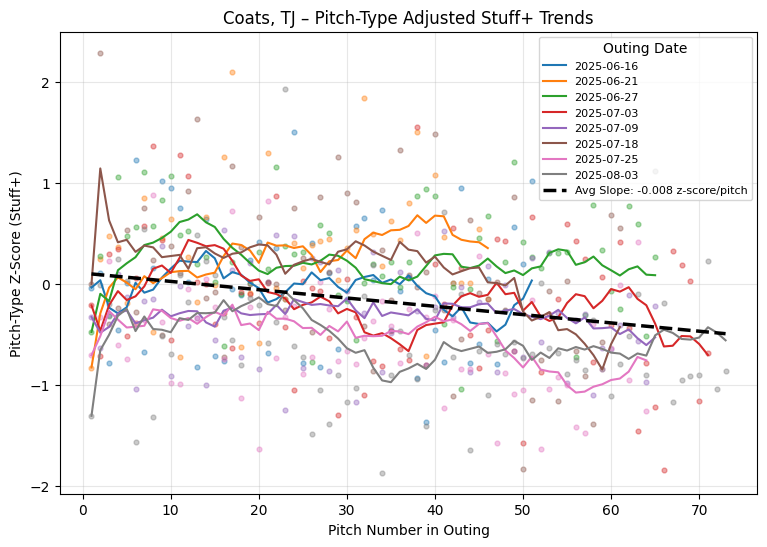

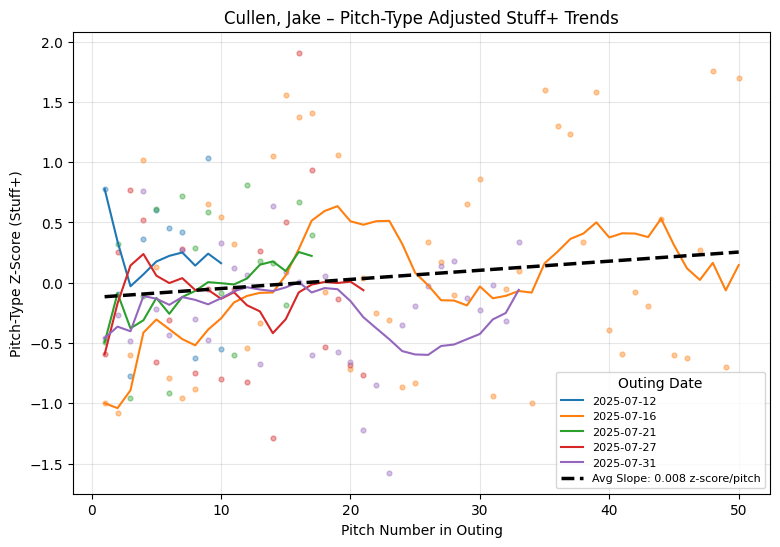

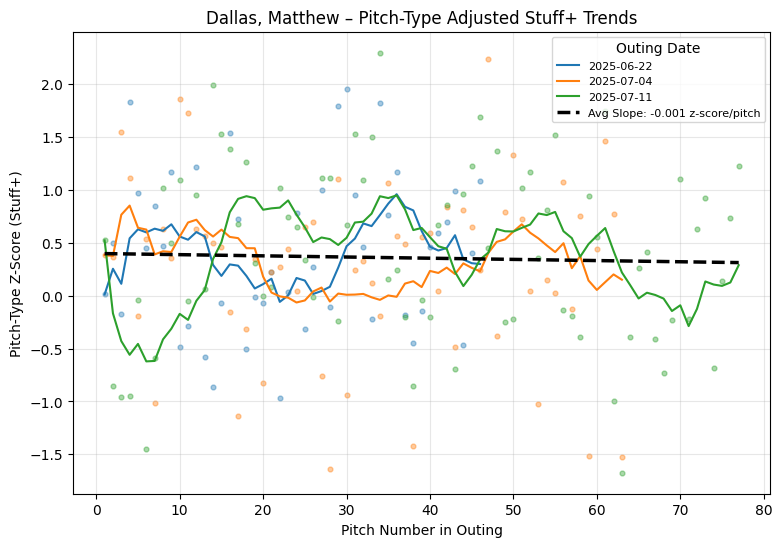

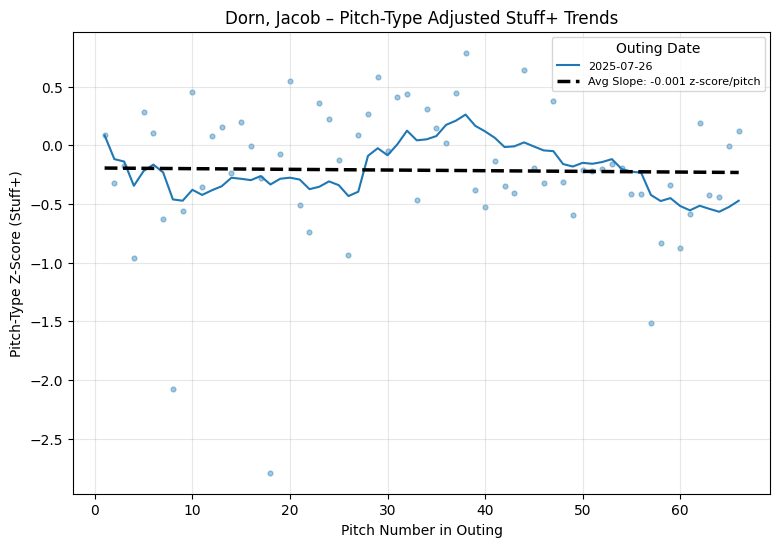

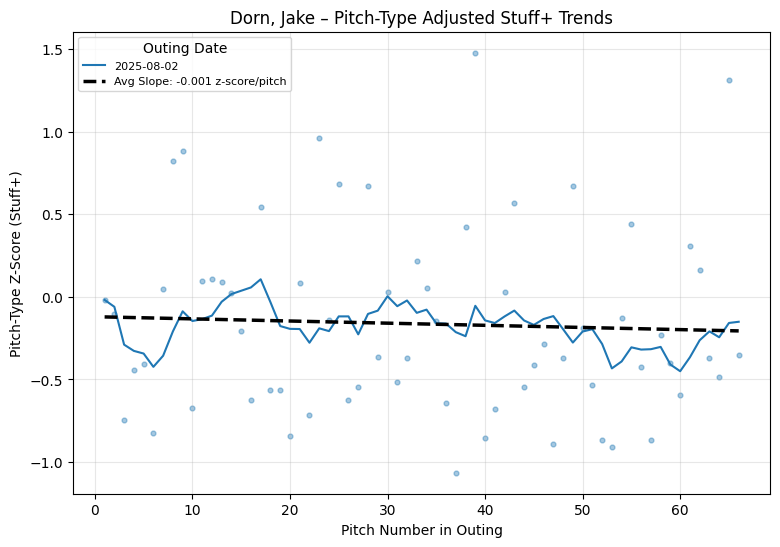

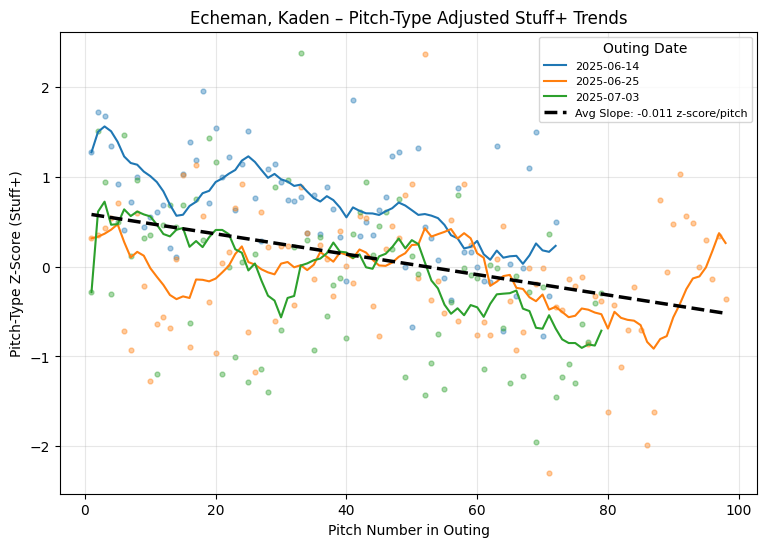

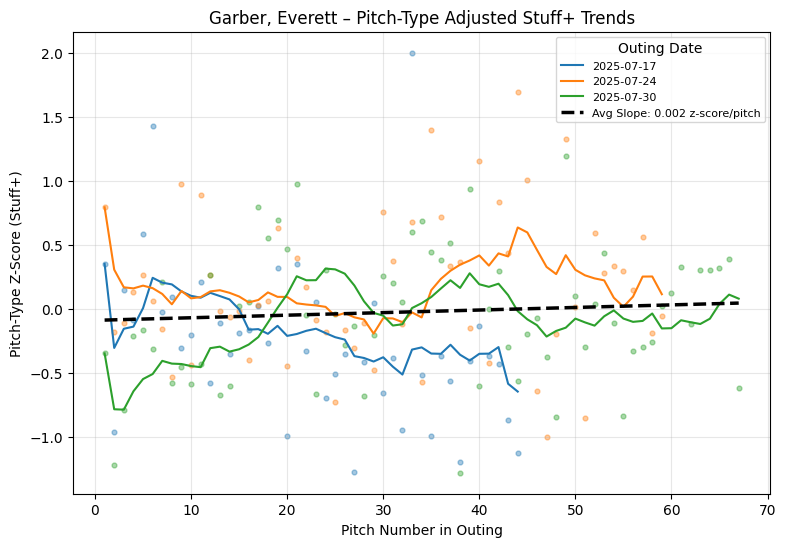

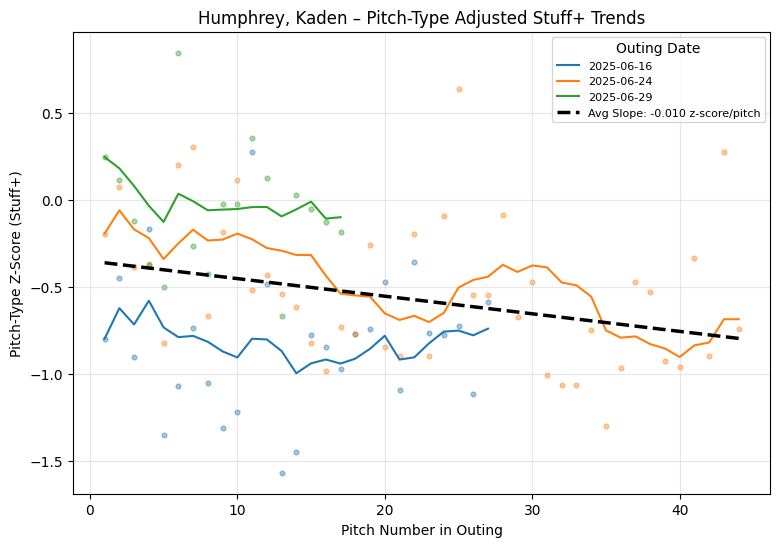

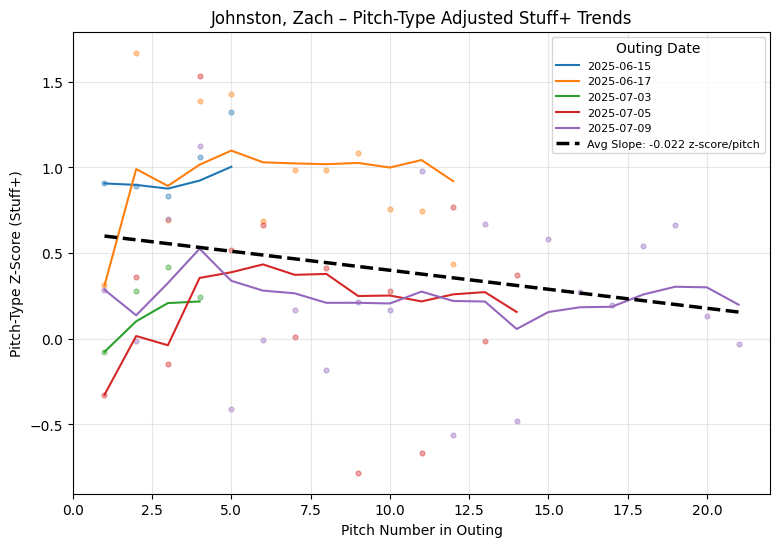

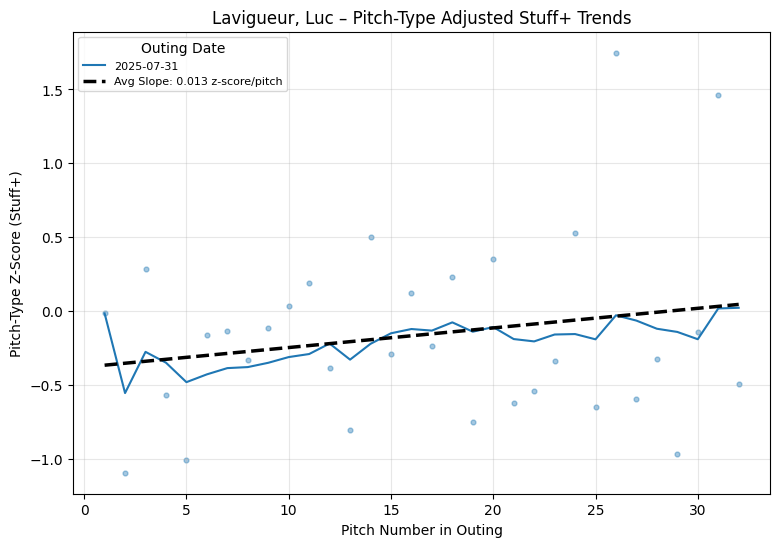

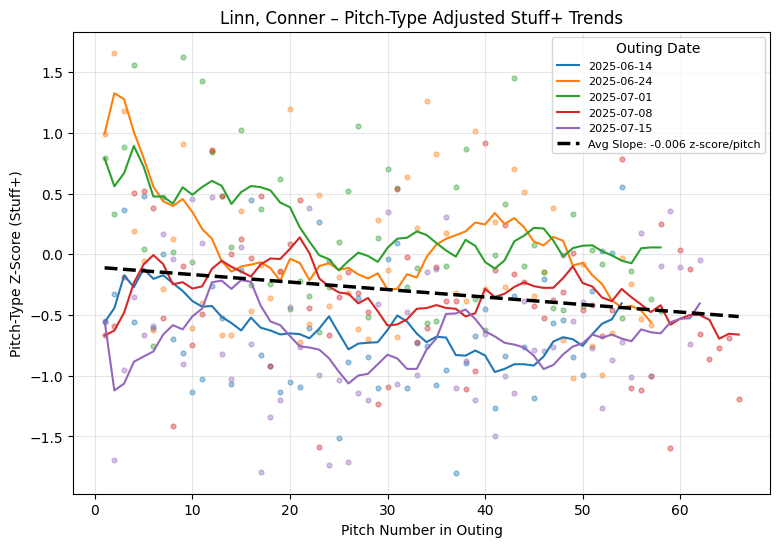

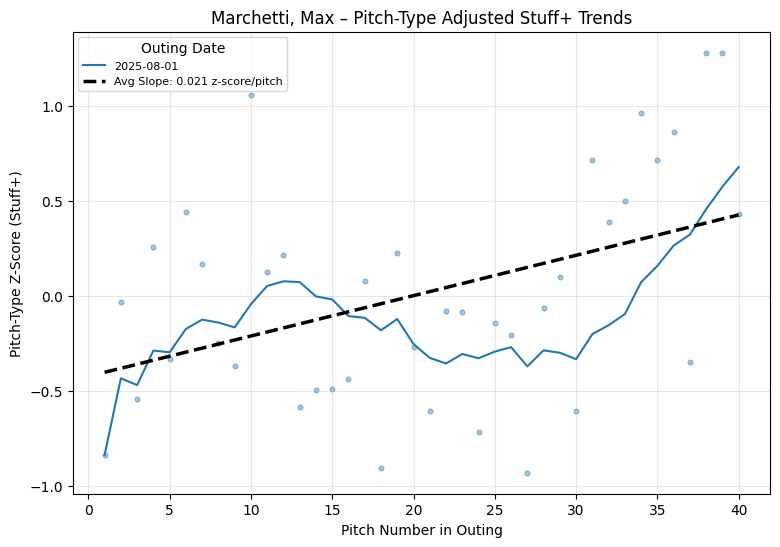

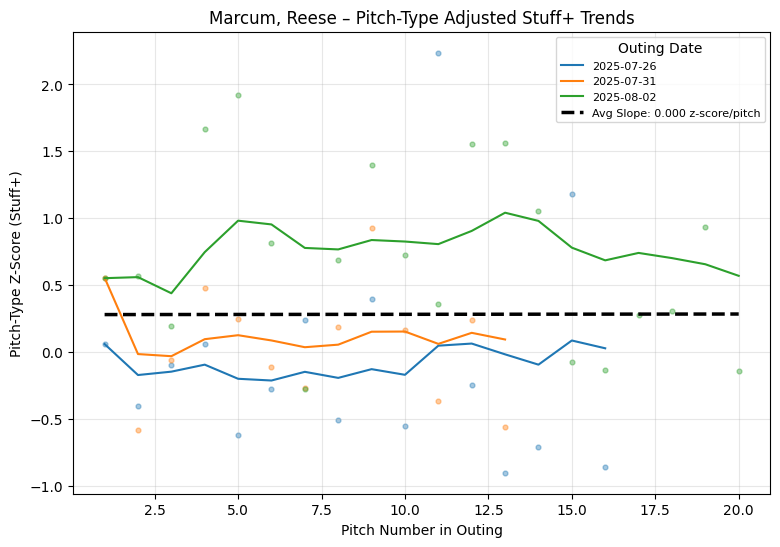

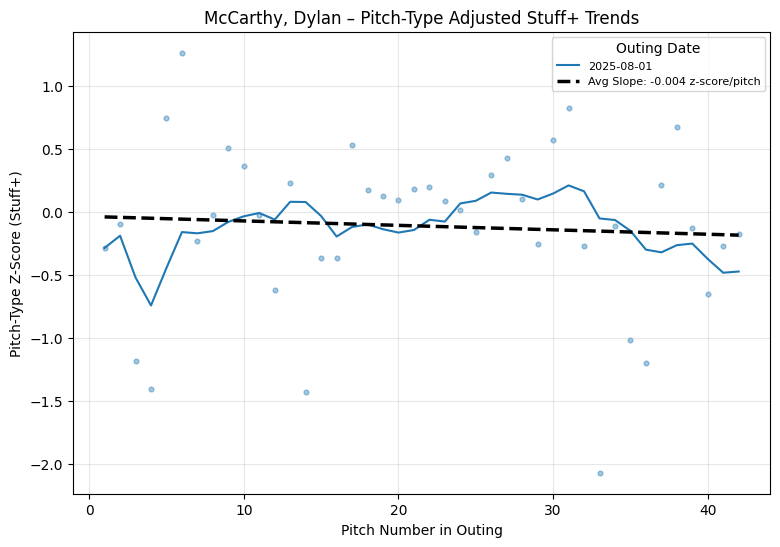

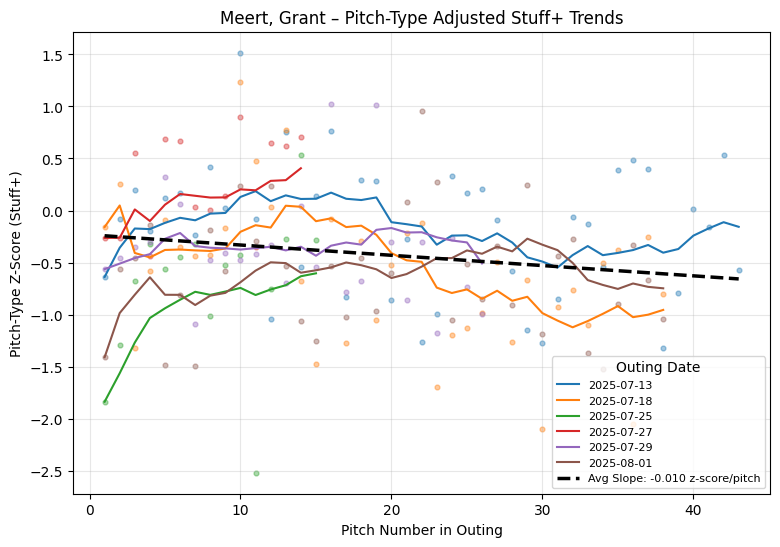

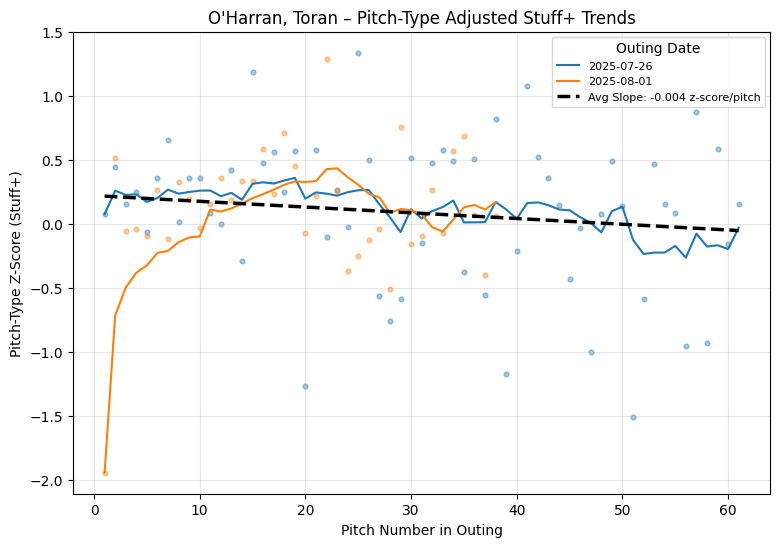

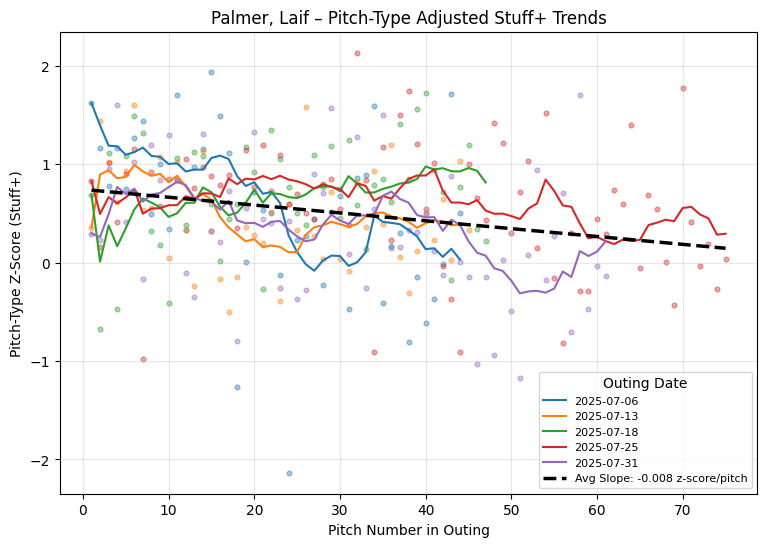

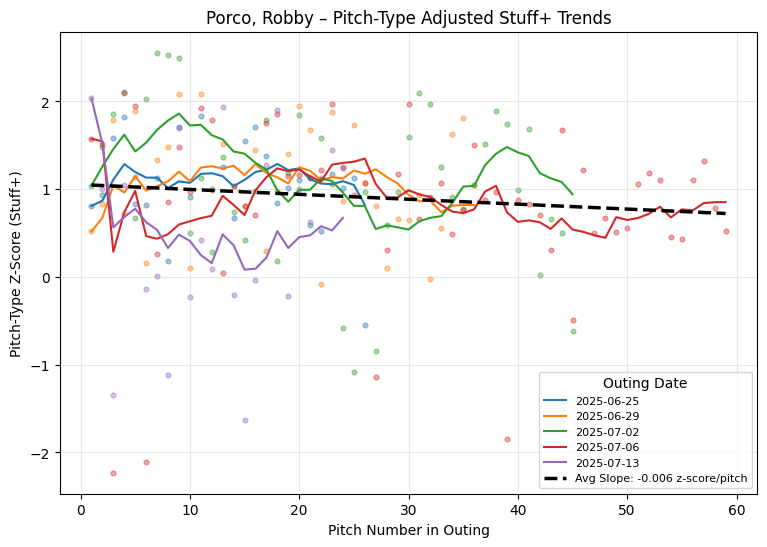

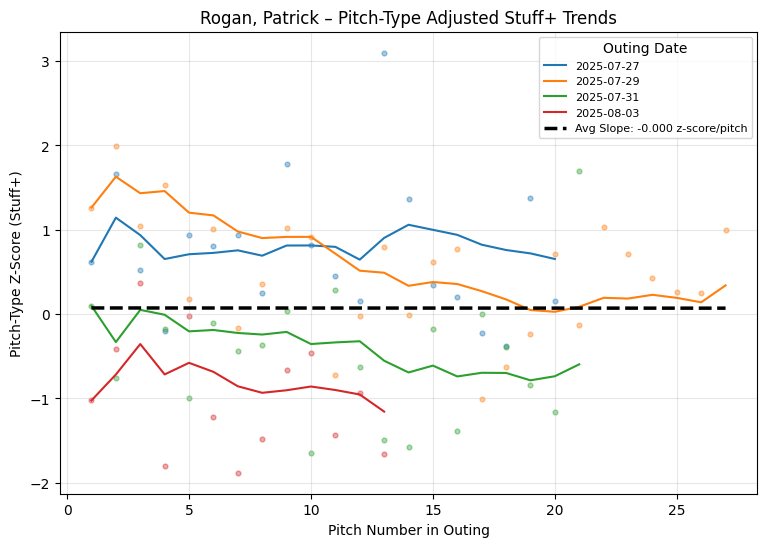

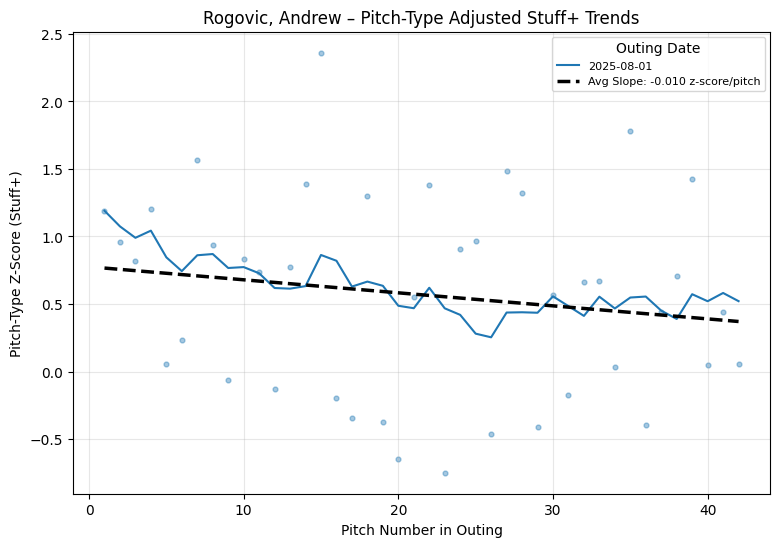

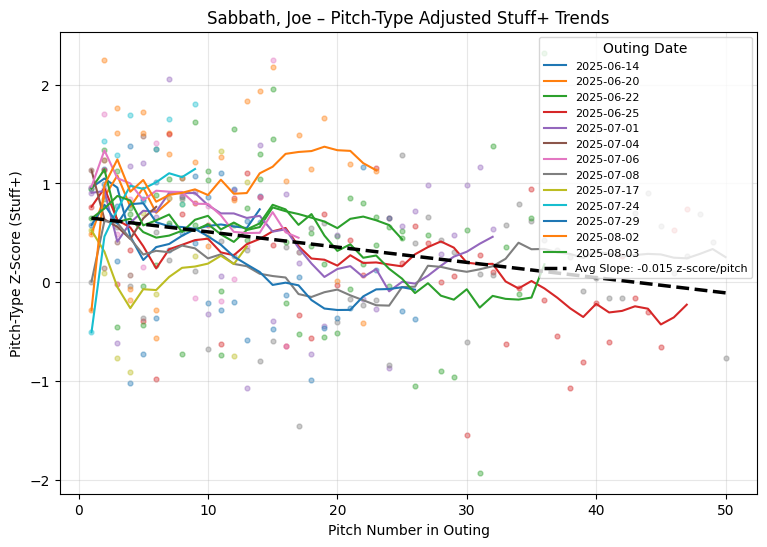

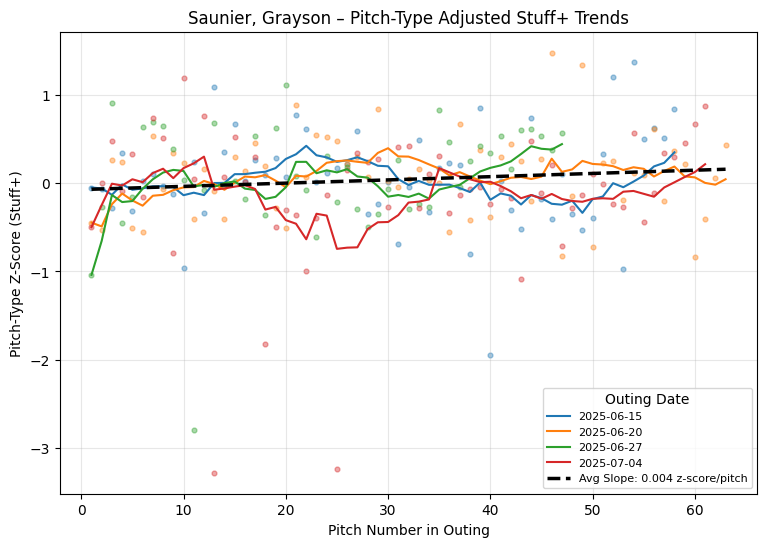

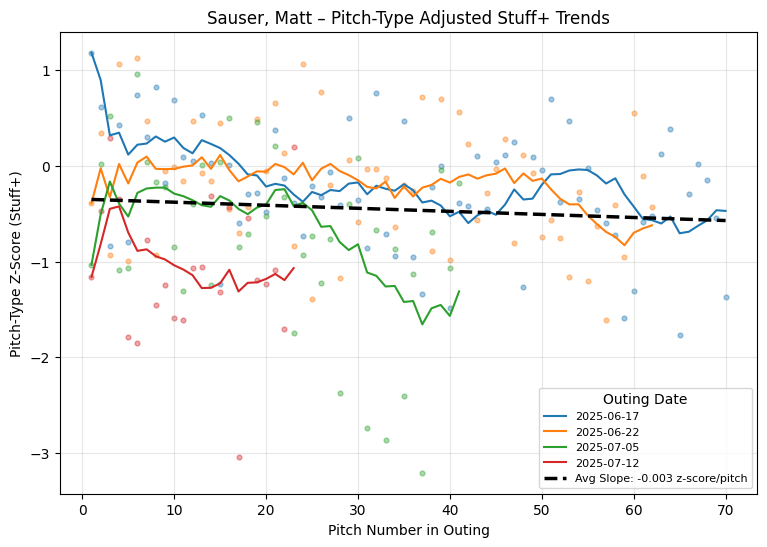

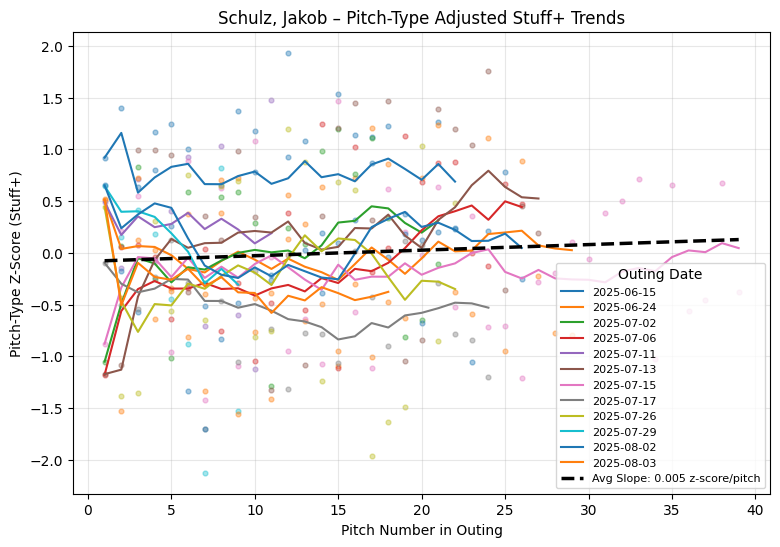

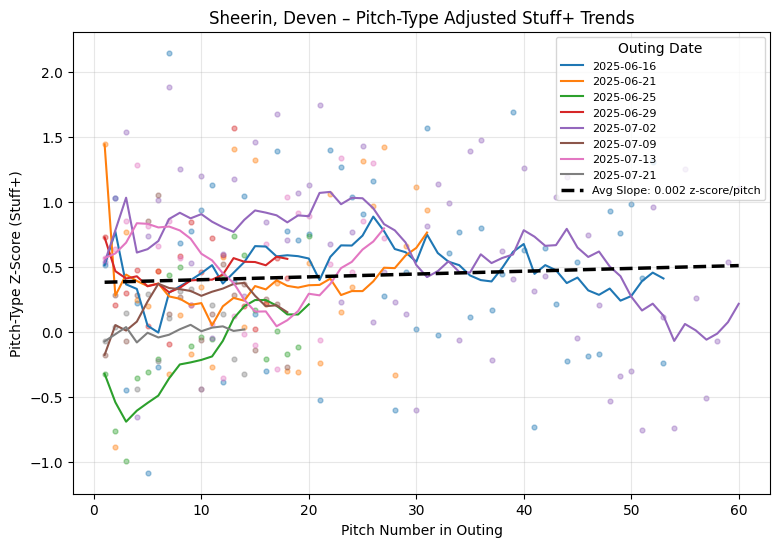

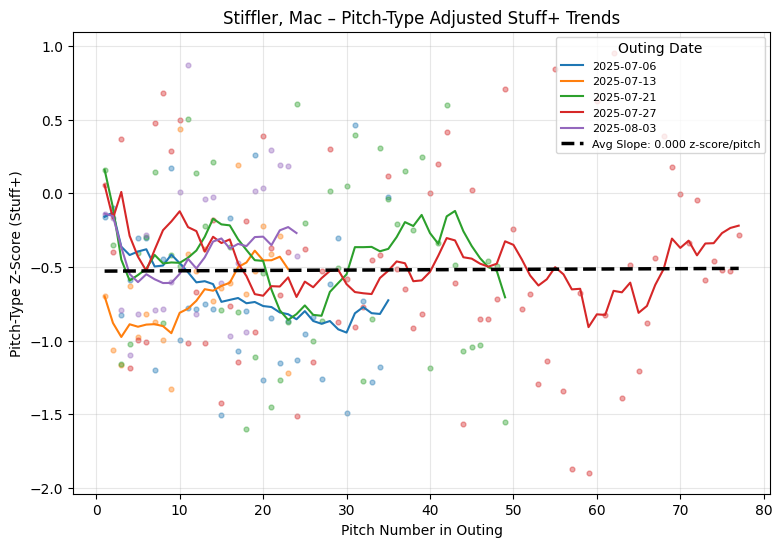

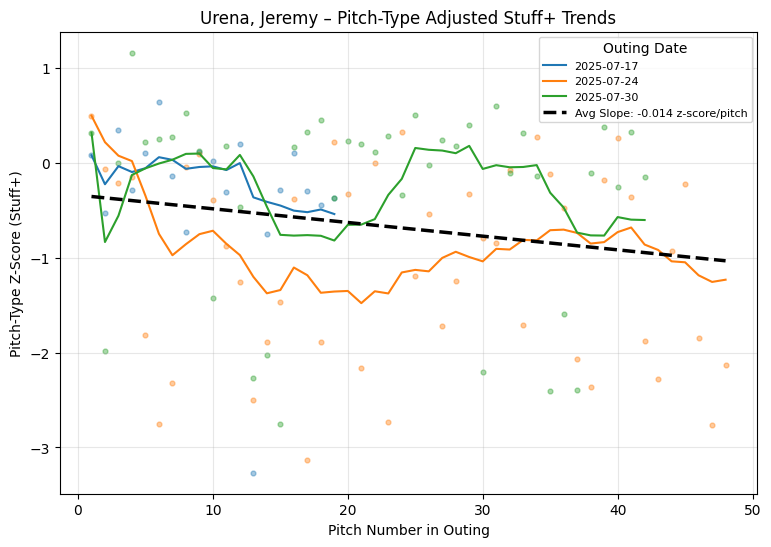

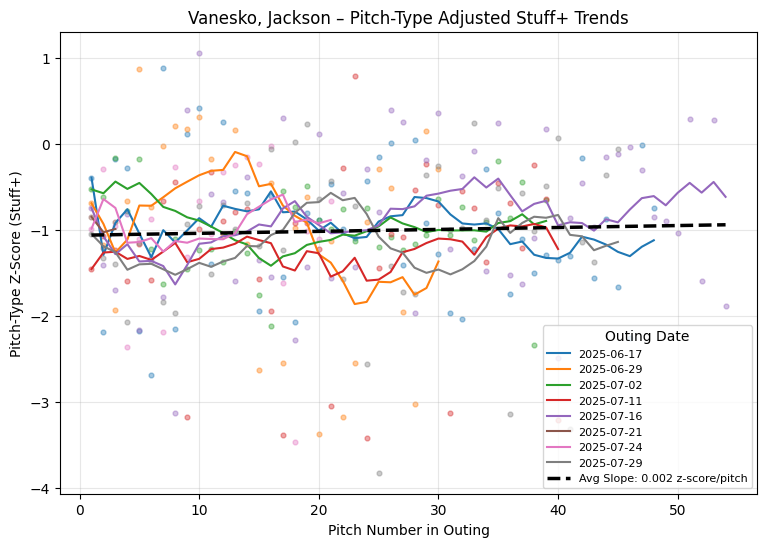

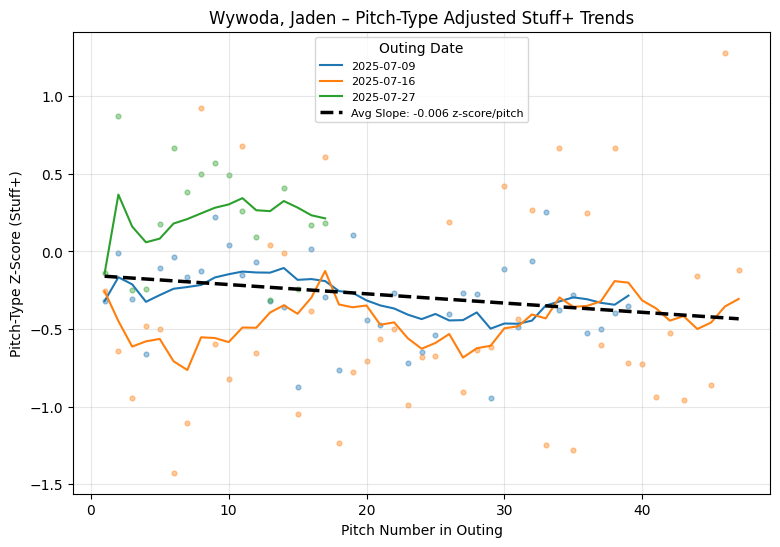

In [33]:
falmouth_df = df_zscored[df_zscored["PitcherTeam"] == "FAL_COM"]

for pitcher, pitcher_group in falmouth_df.groupby("Pitcher"):

    plt.figure(figsize=(9,6))

    for outing_id, group in pitcher_group.groupby("OutingID"):
        date = group["Date"].iloc[0]

        plt.plot(group["PitchNumber"], group["Rolling_StuffPlus_Z"], label=f"{date.strftime('%Y-%m-%d')}")
        plt.scatter(group["PitchNumber"], group["PitchType_Z"], s=12, alpha=0.4)

    X = pitcher_group["PitchNumber"].values.reshape(-1,1)
    y = pitcher_group["PitchType_Z"].values

    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]

    x_fit = np.linspace(1, pitcher_group["PitchNumber"].max(), 100)
    y_fit = model.predict(x_fit.reshape(-1,1))

    plt.plot(x_fit, y_fit, color="black", linewidth=2.5, linestyle="--",
             label=f"Avg Slope: {slope:.3f} z-score/pitch")

    plt.title(f"{pitcher} – Pitch-Type Adjusted Stuff+ Trends")
    plt.xlabel("Pitch Number in Outing")
    plt.ylabel("Pitch-Type Z-Score (Stuff+)")
    plt.legend(title="Outing Date", fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()